In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import os

from scipy.stats import linregress, pearsonr
from scipy.io import loadmat

import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models, Input, Model, activations
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score, confusion_matrix, roc_auc_score, precision_recall_curve, PrecisionRecallDisplay, average_precision_score

from src.mpra_tools.fasta_utils import *
from src.tf_tools.cnn_regression import MCDropout

2024-03-12 11:27:55.950477: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-12 11:27:56.961616: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-12 11:27:58.690817: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 11:27:58.690854: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 11:27:58.698551: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [1]:
folder = "Runs/iterreg_original"
modes = ["Uncertainty","Random"]
folds = [str(i+1) for i in range(10)]
iterations = [str(i) for i in range(13)]

In [7]:

scores = []

for mode in modes:
    for fold in folds:
        for iter in iterations:
            metric_path = os.path.join(folder,mode,fold,iter,'test_metrics.csv')
            metrics = pd.read_csv(metric_path, index_col=0)
            scores.append(metrics.values.flatten())



In [8]:

metrics_df = pd.DataFrame(
    scores,
    columns = ['pcc', 'scc'],
    index = pd.MultiIndex.from_product([modes,folds,iterations],
                                       names = ['Mode', 'Fold', 'Iteration'])
)

In [12]:
mean_metrics_df = metrics_df.groupby(level=[0,2]).mean()

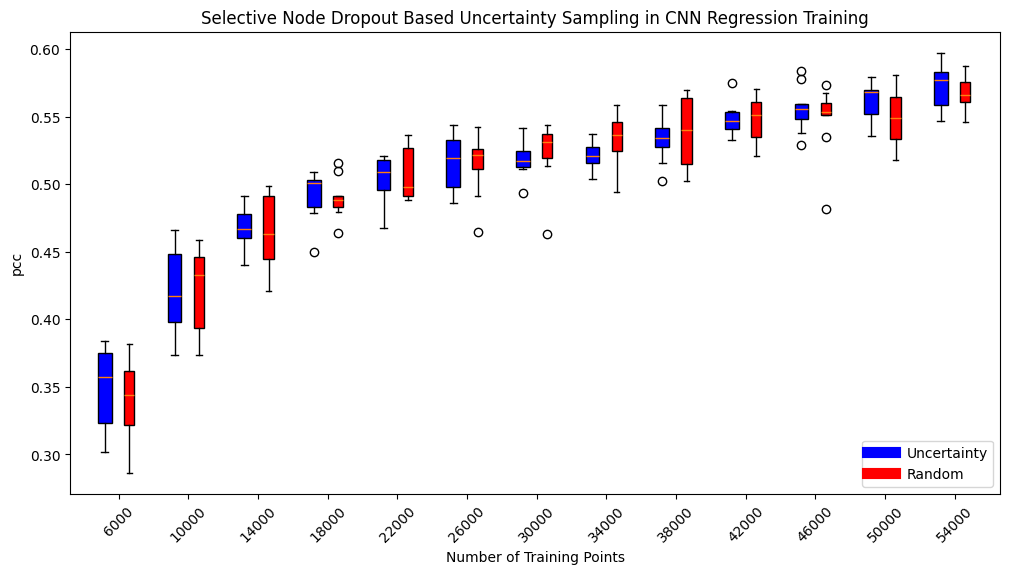

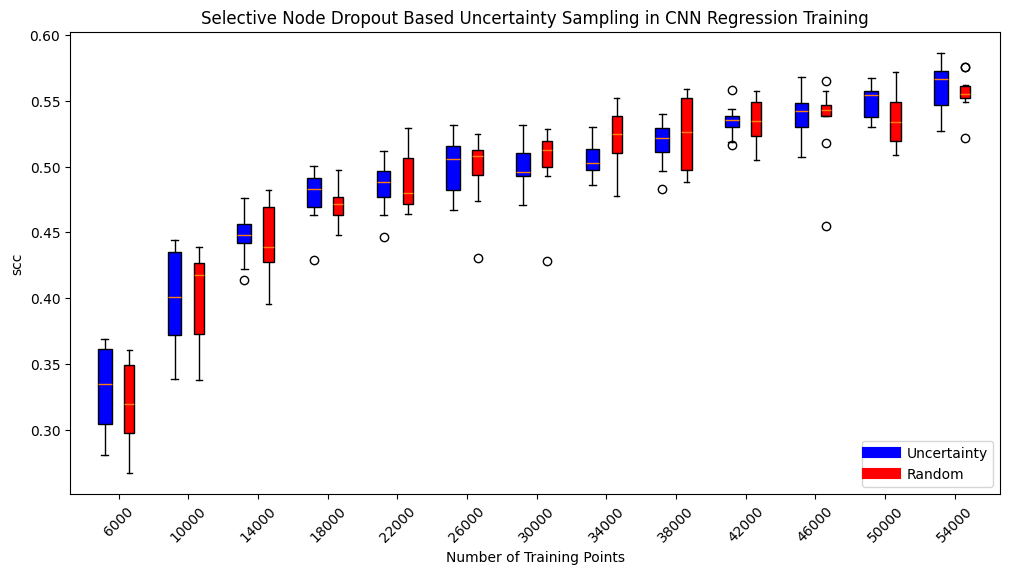

In [54]:
plt.rcParams["figure.figsize"] = (12,6)
ndata = [6000+4000*i for i in range(13)]
for measure in metrics_df.columns:
    plt.clf()
    plt.boxplot([metrics_df.loc["Uncertainty",:,iter][measure] for iter in iterations],
                widths=0.2,
                positions=np.arange(len(iterations))-0.2,
                patch_artist=True, boxprops=dict(facecolor="b"))
    plt.boxplot([metrics_df.loc["Random",:,iter][measure] for iter in iterations],
                widths=0.15,
                positions=np.arange(len(iterations))+0.15,
                patch_artist=True, boxprops=dict(facecolor="r"))
    plt.xticks(ticks=np.arange(13),labels=ndata, rotation=45)
    
    plt.ylabel(measure)
    plt.xlabel('Number of Training Points')
    plt.title('Selective Node Dropout Based Uncertainty Sampling in CNN Regression Training')
    plt.legend([Line2D([0], [0], c='b', lw=8), Line2D([0], [0], c='r', lw=8)], ["Uncertainty", "Random"], loc="lower right")
    plt.show()

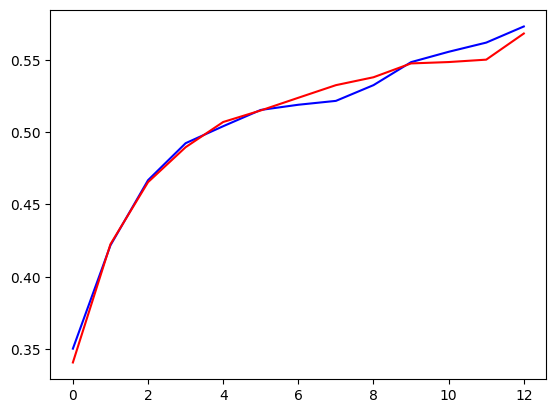

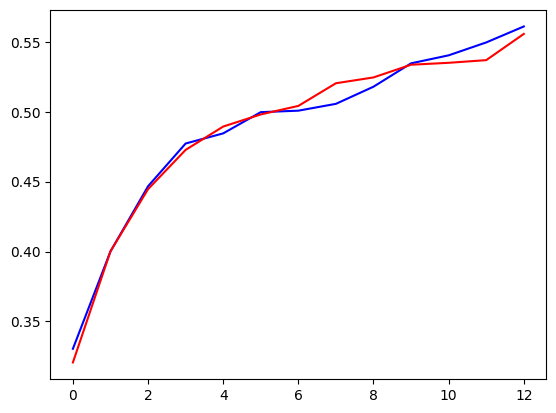

In [23]:
x = np.arange(13)

for measure in metrics_df.columns:
    plt.clf()
    plt.plot(x,[mean_metrics_df.loc["Uncertainty",iter][measure] for iter in iterations], color = 'b')
    plt.plot(x, [mean_metrics_df.loc['Random',iter][measure] for iter in iterations], color = 'r')
    plt.ylabel("Mean "+measure)
    plt.xlabel('Iteration')

    plt.show()

In [26]:
activity_df = pd.read_parquet("Data/activity.parquet")

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '106238', '106239', '106240', '106241', '106242', '106243', '106244',
       '106245', '106246', '106247'],
      dtype='object', length=106248)

In [38]:
unc_exp = []
rand_exp = []

for fold in folds:
    u = []
    r = []
    for iter in iterations:
        unc_path = os.path.join(folder,"Uncertainty",fold,iter,'next_index.line')
        rand_path = os.path.join(folder,"Random",fold,iter, 'next_index.line')
        
        with open(unc_path, 'r') as file:
            data = file.read()
        data = data.split(' ')
        u.append(np.mean(activity_df.loc[data]['expression_log2'].values))
        
        with open(rand_path, 'r') as file:
            data = file.read()
        data = data.split(' ')
        r.append(np.mean(activity_df.loc[data]['expression_log2'].values))
    unc_exp.append(u)
    rand_exp.append(r)
    
unc_exp = np.array(unc_exp)
rand_exp = np.array(rand_exp)

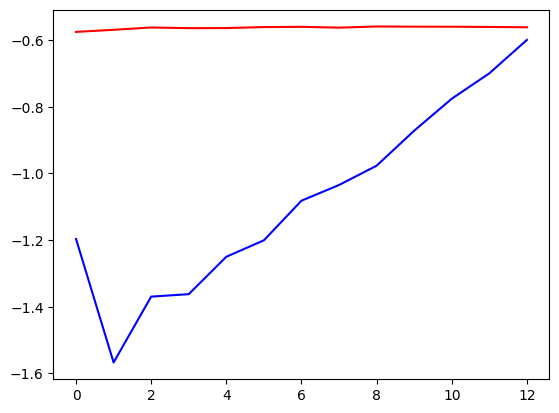

In [41]:

plt.plot(np.arange(13),np.mean(unc_exp, axis=0), c='b')
plt.plot(np.arange(13), np.mean(rand_exp, axis=0), c='r')

plt.show()

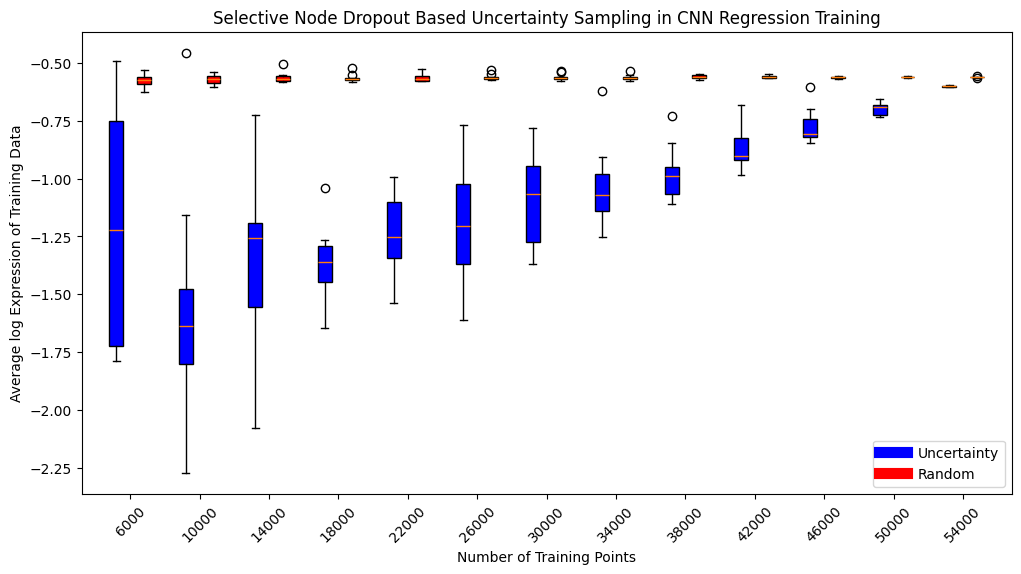

In [55]:
from matplotlib.lines import Line2D


plt.clf()

ndata = [6000+4000*i for i in range(13)]

plt.boxplot([unc_exp[:,int(iter)] for iter in iterations],
                widths=0.2,
                positions=np.arange(len(iterations))-0.2,
                patch_artist=True, boxprops=dict(facecolor="b"))
plt.boxplot([rand_exp[:,int(iter)] for iter in iterations],
            widths=0.2,
            positions=np.arange(len(iterations))+0.2,
            patch_artist=True, boxprops=dict(facecolor="r"))
plt.xticks(ticks=np.arange(13),labels=ndata,rotation=45)

plt.ylabel('Average log Expression of Training Data')
plt.xlabel('Number of Training Points')
plt.title('Selective Node Dropout Based Uncertainty Sampling in CNN Regression Training')
plt.legend([Line2D([0], [0], c='b', lw=8), Line2D([0], [0], c='r', lw=8)], ["Uncertainty", "Random"], loc="lower right")


plt.show()
